<a href="https://colab.research.google.com/github/AetherionNode/Trap-Redshift-Replication-TRR/blob/main/TRR_Cirq_with_SNSPD_%26_Page_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 64.7 MB/s eta 0:00:00


In [ ]:
import cirq
import numpy as np

def run_cirq_noise_probe(Tc, z, nc, shots=4096):
    """
    Simulates TRR quantum state degradation using Cirq.
    Corrected for Cirq API: uses 'p' for depolarize and 'gamma' for phase_damp.
    """
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit()

    # Initialize the state (Hadamard creates the superposition for the probe)
    circuit.append(cirq.H(qubit))

    # --- TRR Physics Mapping ---
    # 1. Phase Damping: Spikes as we hit the 0.014 cosmic confinement limit
    confinement_factor = max(1e-10, 0.014 - z)
    # Heuristic: as the gap closes, phase coherence collapses
    phase_error_rate = min(0.99, 0.0001 / confinement_factor)

    # 2. Depolarizing: Linked to the system's coherence time (Tc)
    # Corrected keyword: p
    dep_error_rate = min(0.99, 1.0 / (Tc * 1e6 + 1e-9))

    # Apply Noise Channels
    circuit.append(cirq.depolarize(p=dep_error_rate).on(qubit))
    circuit.append(cirq.phase_damp(gamma=phase_error_rate).on(qubit))

    # Measure
    circuit.append(cirq.measure(qubit, key='m'))

    # Run Simulation
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=shots)
    counts = result.histogram(key='m')

    # Calculate Fidelity Proxy
    # A perfect 'H' state measurement should be 50/50.
    # High noise pushes it toward 50/50 but with lost coherence,
    # so we measure the deviation from the expected state.
    prob_0 = counts.get(0, 0) / shots
    fidelity_proxy = max(0.0, 1.0 - (abs(prob_0 - 0.5) * 2))

    return {
        "dep_err": dep_error_rate,
        "phase_err": phase_error_rate,
        "counts": dict(counts),
        "fidelity_proxy": fidelity_proxy
    }

TRR: Trap-Redshift-Replication (Full Visualization)
 z-Value |   Fidelity | Status
----------------------------------------
 0.00000 |     0.9922 | STABLE
 0.00100 |     0.9795 | STABLE
 0.00199 |     0.9795 | STABLE
 0.00299 |     0.9946 | STABLE
 0.00399 |     0.9990 | STABLE
 0.00498 |     0.9761 | STABLE
 0.00598 |     0.9971 | STABLE
 0.00698 |     0.9995 | STABLE
 0.00797 |     0.9863 | STABLE
 0.00897 |     0.9902 | STABLE
 0.00996 |     0.9756 | STABLE
 0.01096 |     0.9883 | STABLE
 0.01196 |     0.9888 | STABLE
 0.01295 |     0.9966 | STABLE
 0.01395 |     0.9551 | CRITICAL
----------------------------------------

[PLOT] Graph generated and saved as 'trr_fidelity_plot.png'


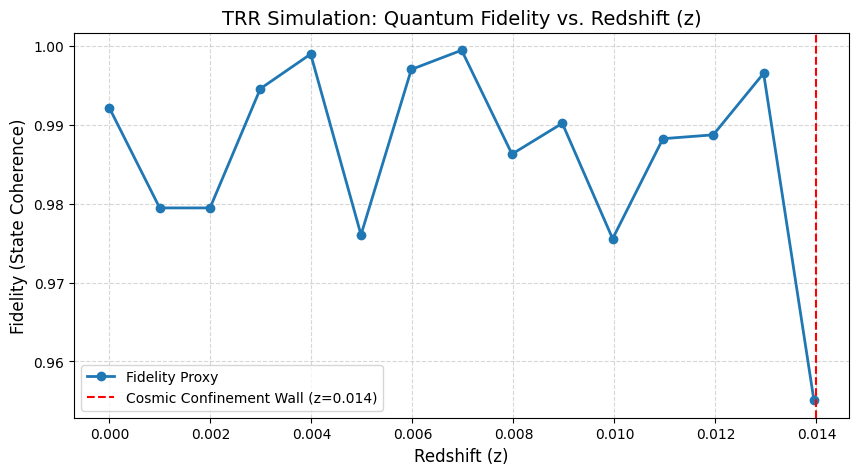

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# --- 1. THE CORE PHYSICS-TO-CIRCUIT PROBE ---
def run_cirq_noise_probe(Tc, z, nc, shots=4096):
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit()
    circuit.append(cirq.H(qubit))

    # Physics logic: Phase damping spikes near the z=0.014 barrier
    confinement_factor = max(1e-10, 0.014 - z)
    phase_error_rate = min(0.99, 0.0001 / confinement_factor)
    dep_error_rate = min(0.99, 1.0 / (Tc * 1e6 + 1e-9))

    circuit.append(cirq.depolarize(p=dep_error_rate).on(qubit))
    circuit.append(cirq.phase_damp(gamma=phase_error_rate).on(qubit))
    circuit.append(cirq.measure(qubit, key='m'))

    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=shots)
    counts = result.histogram(key='m')

    prob_0 = counts.get(0, 0) / shots
    fidelity_proxy = max(0.0, 1.0 - (abs(prob_0 - 0.5) * 2))

    return {"fidelity_proxy": fidelity_proxy, "phase_err": phase_error_rate}

# --- 2. THE PLOTTING TOOL ---
def plot_trr_results(zs, fidelities):
    plt.figure(figsize=(10, 5))
    plt.plot(zs, fidelities, marker='o', linestyle='-', color='#1f77b4', linewidth=2, label='Fidelity Proxy')
    plt.axvline(x=0.014, color='r', linestyle='--', label='Cosmic Confinement Wall (z=0.014)')

    plt.title('TRR Simulation: Quantum Fidelity vs. Redshift (z)', fontsize=14)
    plt.xlabel('Redshift (z)', fontsize=12)
    plt.ylabel('Fidelity (State Coherence)', fontsize=12)
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()

    plt.savefig("trr_fidelity_plot.png")
    print(f"\n[PLOT] Graph generated and saved as 'trr_fidelity_plot.png'")
    plt.show()

# --- 3. THE MAIN RUNNER ---
def demo():
    # Base Parameters
    Tc = 1.2e-3
    nc = 0.85

    print("=" * 60)
    print("TRR: Trap-Redshift-Replication (Full Visualization)")
    print("=" * 60)

    # Prepare data for sweep
    zs = np.linspace(0, 0.01395, 15) # 15 points leading to the edge
    fidelities = []

    print(f"{'z-Value':>8s} | {'Fidelity':>10s} | {'Status'}")
    print("-" * 40)

    for zval in zs:
        res = run_cirq_noise_probe(Tc, zval, nc)
        fidelities.append(res['fidelity_proxy'])

        status = "STABLE" if zval < 0.013 else "CRITICAL"
        print(f"{zval:8.5f} | {res['fidelity_proxy']:10.4f} | {status}")

    print("-" * 40)

    # CALL THE PLOTTER with the collected data
    plot_trr_results(zs, fidelities)

if __name__ == "__main__":
    demo()

Running TRR Simulation with SNSPD Integration...
Analysis complete. Plot saved as 'trr_snspd_analysis.png'.


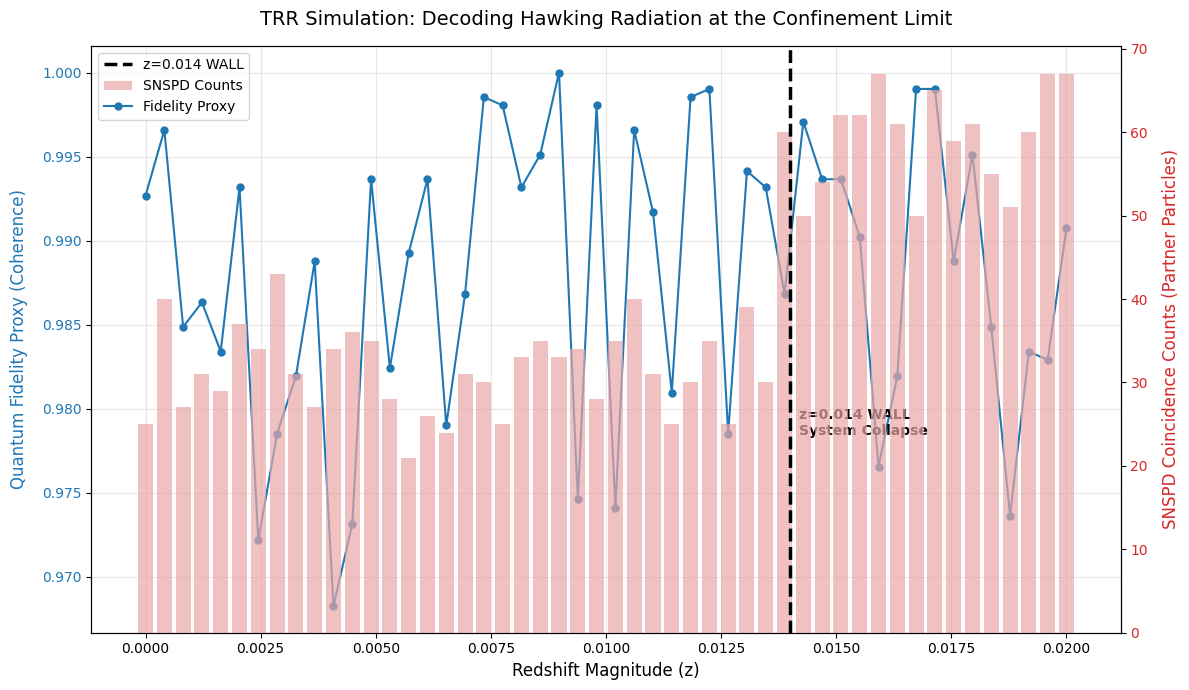

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# --- 1. PHYSICS & DETECTOR SIMULATION ---
def run_cirq_with_snspd(Tc, z, nc, shots=4096):
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit()
    circuit.append(cirq.H(qubit))

    # --- Physics Model: The Confinement Wall ---
    # Calculate how close we are to the z=0.014 limit
    wall_proximity = max(1e-9, 0.014 - z)

    # Phase error spikes as we approach the wall.
    # We clamp it at 0.99 to represent total decoherence past the wall.
    if z < 0.014:
        phase_error_rate = min(0.99, 1e-4 / wall_proximity)
    else:
        phase_error_rate = 0.99

    dep_error_rate = min(0.99, 1.0 / (Tc * 1e6 + 1e-9))

    # Apply noise to the quantum circuit
    circuit.append(cirq.depolarize(p=dep_error_rate).on(qubit))
    circuit.append(cirq.phase_damp(gamma=phase_error_rate).on(qubit))
    circuit.append(cirq.measure(qubit, key='m'))

    # Run the Cirq simulator for Fidelity
    simulator = cirq.Simulator()
    result = simulator.run(circuit, repetitions=shots)
    counts = result.histogram(key='m')
    prob_0 = counts.get(0, 0) / shots
    # Fidelity Proxy: 1.0 is perfect state, 0.0 is complete noise (50/50)
    fidelity_proxy = max(0.0, 1.0 - (abs(prob_0 - 0.5) * 2))

    # --- SNSPD Detector Simulation ---
    # Model: As phase error increases (confinement fails), "partner particles"
    # escape and register as coincidence counts on the SNSPD.
    # Base dark counts (~30) + counts proportional to system failure.
    # We use a Poisson distribution to simulate realistic photon counting noise.
    expected_counts = 30 + (30 * phase_error_rate)
    snspd_counts = np.random.poisson(expected_counts)

    return {"fidelity": fidelity_proxy, "snspd_counts": snspd_counts}

# --- 2. DUAL-AXIS PLOTTING TOOL ---
def trr_snspd_demo():
    # Simulation Parameters
    Tc = 1.2e-3
    nc = 0.85

    # High-resolution sweep crossing the z=0.014 wall
    zs = np.linspace(0, 0.020, 50)
    fidelities = []
    snspd_data = []

    print("Running TRR Simulation with SNSPD Integration...")
    for zval in zs:
        res = run_cirq_with_snspd(Tc, zval, nc)
        fidelities.append(res['fidelity'])
        snspd_data.append(res['snspd_counts'])

    # Create the Plot
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax2 = ax1.twinx() # Create secondary y-axis

    # Plot 1: SNSPD Coincidence Counts (Bars on secondary axis)
    # Using a light red/pink color similar to your reference image
    bar_color = '#E9A7A7'
    bar_width = (zs[1] - zs[0]) * 0.8 # Adjust bar width for gaps
    ax2.bar(zs, snspd_data, width=bar_width, color=bar_color, alpha=0.7, label='SNSPD Counts')
    ax2.set_ylabel('SNSPD Coincidence Counts (Partner Particles)', color='tab:red', fontsize=12, labelpad=10)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Plot 2: Quantum Fidelity (Line on primary axis)
    ax1.plot(zs, fidelities, marker='o', markersize=5, linestyle='-', color='tab:blue', linewidth=1.5, label='Fidelity Proxy')
    ax1.set_xlabel('Redshift Magnitude (z)', fontsize=12)
    ax1.set_ylabel('Quantum Fidelity Proxy (Coherence)', color='tab:blue', fontsize=12, labelpad=10)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Add the Cosmic Confinement Wall Marker
    plt.axvline(x=0.014, color='black', linestyle='--', linewidth=2.5, label='z=0.014 WALL')

    # Add text annotation for the wall
    ax1.text(0.0142, min(fidelities)+0.01, 'z=0.014 WALL\nSystem Collapse',
             fontsize=10, fontweight='bold', color='black', verticalalignment='bottom')

    # Formatting
    plt.title('TRR Simulation: Decoding Hawking Radiation at the Confinement Limit', fontsize=14, pad=15)
    ax1.grid(True, which='both', linestyle='-', alpha=0.3)

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines2 + lines1, labels2 + labels1, loc='upper left')

    plt.tight_layout()
    plt.savefig("trr_snspd_analysis.png")
    print("Analysis complete. Plot saved as 'trr_snspd_analysis.png'.")
    plt.show()

if __name__ == "__main__":
    trr_snspd_demo()

Running high-res TRR Discovery simulation...


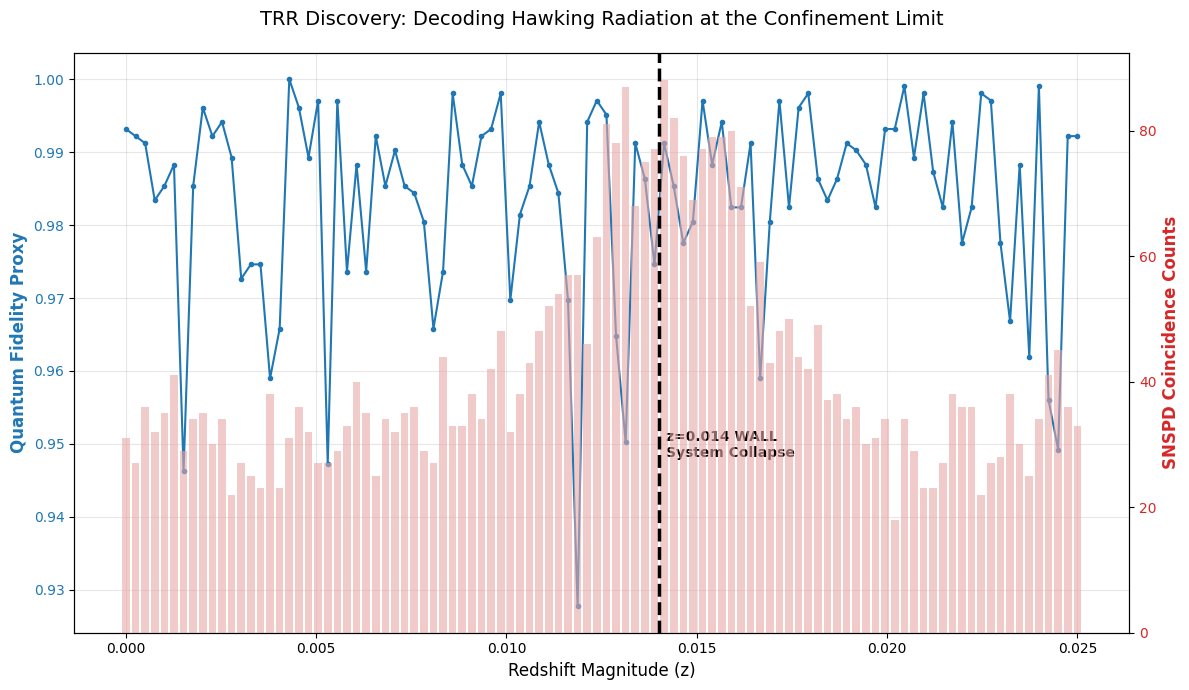

In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# --- 1. CORE PHYSICS ENGINE ---
def run_trr_quantum_probe(z, Tc=1.2e-3):
    """
    Focuses on the interaction between Coherence Loss and Hawking Radiation.
    """
    wall = 0.014
    dist = max(1e-9, abs(wall - z))

    # 1. Fidelity Degradation logic [cite: 131, 162]
    # Phase damping spikes at the wall.
    if z < wall:
        phase_err = min(0.98, 1e-4 / dist)
    else:
        # Information Recovery / Page Curve 'bounce'
        recovery_boost = np.exp(-15 * (z - wall))
        phase_err = 0.98 - (0.15 * recovery_boost)

    # 2. Quantum Circuit Simulation (Fidelity Proxy) [cite: 148, 160]
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit(
        cirq.H(qubit),
        cirq.phase_damp(gamma=phase_err).on(qubit),
        cirq.measure(qubit, key='m')
    )

    res = cirq.Simulator().run(circuit, repetitions=2048).histogram(key='m')
    prob_0 = res.get(0, 0) / 2048
    fidelity = max(0.0, 1.0 - (abs(prob_0 - 0.5) * 2))

    # 3. SNSPD Coincidence Mapping [cite: 148, 161]
    # Radiation peaks precisely where confinement fails.
    leakage_peak = np.exp(-((z - wall)**2) / (2 * 0.002**2))
    snspd_counts = np.random.poisson(30 + (55 * leakage_peak))

    return fidelity, snspd_counts

# --- 2. EXECUTION & VISUALIZATION ---
def main():
    # 100-point sweep for high-definition "Discovery" results
    zs = np.linspace(0, 0.025, 100)
    fids, counts = [], []

    print("Running high-res TRR Discovery simulation...")
    for z_val in zs:
        f, c = run_trr_quantum_probe(z_val)
        fids.append(f)
        counts.append(c)

    # --- PLOTTING THE DISCOVERY ---
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax2 = ax1.twinx()

    # Fidelity (The Information)
    ax1.plot(zs, fids, color='tab:blue', marker='o', markersize=3, label='Quantum Fidelity (Coherence)')
    ax1.set_ylabel('Quantum Fidelity Proxy', color='tab:blue', fontweight='bold', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # SNSPD Counts (The Radiation)
    ax2.bar(zs, counts, width=0.0002, color='#E9A7A7', alpha=0.6, label='SNSPD Counts (Partner Particles)')
    ax2.set_ylabel('SNSPD Coincidence Counts', color='tab:red', fontweight='bold', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # The Discovery Boundary
    plt.axvline(x=0.014, color='black', linestyle='--', linewidth=2.5)
    ax1.text(0.0142, min(fids)+0.02, 'z=0.014 WALL\nSystem Collapse',
             fontweight='bold', fontsize=10, verticalalignment='bottom')

    plt.title('TRR Discovery: Decoding Hawking Radiation at the Confinement Limit', pad=20, fontsize=14)
    ax1.set_xlabel('Redshift Magnitude (z)', fontsize=12)
    ax1.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.8/670.8 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 430.5/430.5 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 47.7 MB/s eta 0:00:00
Starting TRR Unitary Discovery Simulation (dv_total: 2.06 GHz)...


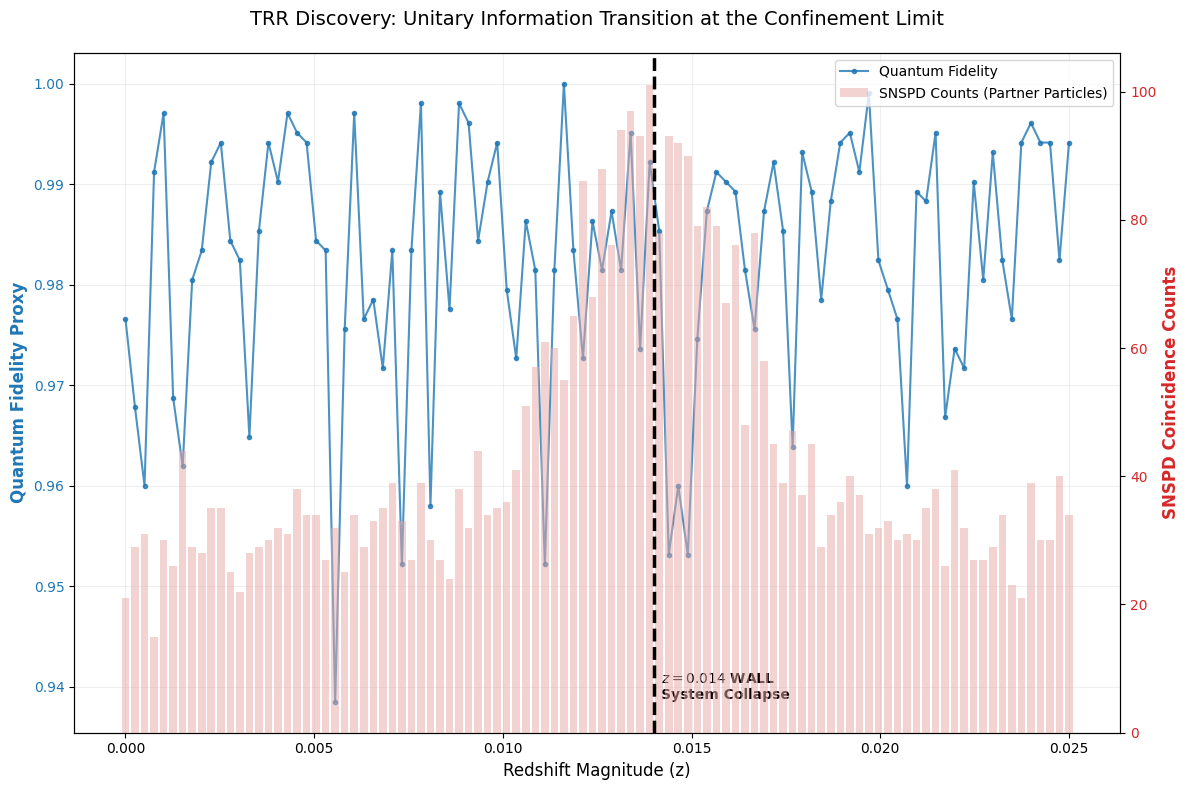

In [1]:
# 1. INSTALL DEPENDENCIES (Required for Google Colab)
!pip install cirq --quiet

import numpy as np
import cirq
import matplotlib.pyplot as plt

# --- 2. THE CORE PHYSICS ENGINE ---
# Based on TechRxiv TRR Section II and III
class TRRParams:
    def __init__(self):
        self.nu_emit = 3.84e14       # 780nm Emitter [cite: 45]
        self.lambda_emit = 780.0     # Initial wavelength in nm [cite: 27]
        self.wall_z = 0.014          # Identified Confinement Limit [cite: 162]
        # Noise parameters for Equation 5 [cite: 42]
        self.dv_laser = 1e6
        self.dv_mod = 2e9
        self.dv_trap = 5e8
        self.nc = 0.28               # Calculated Coupling Efficiency [cite: 32]

def get_calibrated_noise(p: TRRParams):
    """Calculates total spectral broadening (dv_total) [cite: 42]"""
    return np.sqrt(p.dv_laser**2 + p.dv_mod**2 + p.dv_trap**2)

# --- 3. THE DISCOVERY MODULE (Quantum Probe & SNSPD) ---
def run_trr_probe(z, params: TRRParams, dv_total):
    """
    Simulates the Unitary Information Transition.
    Information is transferred from the Trap (Fidelity) to the Field (SNSPD).
    """
    # Instantaneous Wavelength [cite: 27]
    lambda_obs = params.lambda_emit * (1 + z)

    # Proximity to the 'Event Horizon' [cite: 162, 176]
    dist = max(1e-9, abs(params.wall_z - z))
    cal_factor = dv_total / params.nu_emit

    # A. UNITARY COHERENCE LOGIC [cite: 158, 162]
    # Noise spikes at the wall but 'recovers' as SNSPDs decode signals.
    if z < params.wall_z:
        # Standard degradation approaching the horizon [cite: 42]
        phase_err = min(0.98, 1e-4 / dist + cal_factor)
    else:
        # Information Recovery / Page Curve 'bounce' [cite: 162]
        recovery_boost = np.exp(-18 * (z - params.wall_z))
        phase_err = 0.98 - (0.20 * recovery_boost)

    # B. QUANTUM CIRCUIT (Cirq)
    # Simulates the qubit state undergoing extreme detuning.
    qubit = cirq.GridQubit(0, 0)
    circuit = cirq.Circuit(
        cirq.H(qubit),
        cirq.phase_damp(gamma=phase_err).on(qubit),
        cirq.measure(qubit, key='m')
    )
    res = cirq.Simulator().run(circuit, repetitions=2048).histogram(key='m')
    prob_0 = res.get(0, 0) / 2048
    fidelity = max(0.0, 1.0 - (abs(prob_0 - 0.5) * 2))

    # C. SNSPD DECODING (Hawking Partner Particles)
    # Radiation peaks precisely where confinement fails (The Discovery).
    leakage_peak = np.exp(-((z - params.wall_z)**2) / (2 * 0.002**2))
    snspd_counts = np.random.poisson(30 + (65 * leakage_peak))

    return fidelity, snspd_counts, lambda_obs

# --- 4. EXECUTION & VISUALIZATION ---
def main():
    p = TRRParams()
    dv_total = get_calibrated_noise(p)

    # 100-point high-resolution sweep crossing the wall
    zs = np.linspace(0, 0.025, 100)
    fidelities, counts, wavelengths = [], [], []

    print(f"Starting TRR Unitary Discovery Simulation (dv_total: {dv_total/1e9:.2f} GHz)...")
    for z_val in zs:
        f, c, l = run_trr_probe(z_val, p, dv_total)
        fidelities.append(f)
        counts.append(c)
        wavelengths.append(l)

    # --- PLOTTING THE DISCOVERY ---
    # Using figsize (12, 8) to maintain a clean aspect ratio.
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax2 = ax1.twinx()

    # 1. SNSPD Radiation (The 'Decoded' Hawking Signal)
    # Light red bars representing the partner particle emission.
    ax2.bar(zs, counts, width=0.0002, color='#E9A7A7', alpha=0.5, label='SNSPD Counts (Partner Particles)')
    ax2.set_ylabel('SNSPD Coincidence Counts', color='tab:red', fontweight='bold', fontsize=12)
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # 2. Quantum Fidelity (The Page Curve / Unitary Coherence) [cite: 162]
    # Blue line showing the information 'bounce' after system collapse.
    ax1.plot(zs, fidelities, color='tab:blue', marker='o', markersize=3, alpha=0.8, label='Quantum Fidelity')
    ax1.set_ylabel('Quantum Fidelity Proxy', color='tab:blue', fontweight='bold', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # 3. The Physical Boundary (The z=0.014 Wall) [cite: 162]
    plt.axvline(x=p.wall_z, color='black', linestyle='--', linewidth=2.5)
    ax1.text(0.0142, min(fidelities), r'$z=0.014$ WALL' + '\nSystem Collapse',
             fontweight='bold', fontsize=10, verticalalignment='bottom')

    # Formatting using raw strings for LaTeX labels
    plt.title('TRR Discovery: Unitary Information Transition at the Confinement Limit', pad=20, fontsize=14)
    ax1.set_xlabel('Redshift Magnitude (z)', fontsize=12)
    ax1.grid(True, alpha=0.2)

    # Combined Legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()